In [25]:
import os
import time
import math
import itertools
import yaml
import numpy as np
import pandas as pd
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
from scipy.optimize import minimize, Bounds
from hypernet_MLP import Hypernet_MLP
from hypernet_trans import Hypernet_trans

In [2]:
def set_seed(seed=702):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)

set_seed(702)

In [4]:
case = "_Ex_7_1"

# Const

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
print(f"Using device: {device}")

Using device: cpu


In [6]:
GROUND_TRUTH_FILE = f"../4_Pareto_front/test/{case}/pf_dynamic_true.npy" 

if os.path.exists(GROUND_TRUTH_FILE):
    pf_true = np.load(GROUND_TRUTH_FILE)
    print(f"✅ Đã tải ground truth Pareto front từ: {GROUND_TRUTH_FILE}, Shape: {pf_true.shape}")
else:
    print(f"❌ KHÔNG tìm thấy file ground truth tại: {GROUND_TRUTH_FILE}")

✅ Đã tải ground truth Pareto front từ: ../4_Pareto_front/test/_Ex_7_1/pf_dynamic_true.npy, Shape: (20, 2)


# Def

In [7]:
import autograd.numpy as np
from scipy.optimize import minimize            
        
class Projection:
    def __init__(self, cons, bounds, dim, proj_type='euclid'):
        self.cons = cons
        self.bounds = bounds
        self.dim = dim
        self.proj_type = proj_type
        
        if self.proj_type == 'qplus':
            self.objective_func = self._obj_positive_diff
        elif self.proj_type == 'euclid':
            self.objective_func = self._obj_l2_norm
        else:
            print(f"Phép chiếu {self.objective_func} không cài đặt, chọn 'qplus' hoặc 'euclid'")

    def _obj_l2_norm(self, x, y):
        return np.sqrt(np.sum((x - y)**2))
    
    def _obj_positive_diff(self, x, y):
        v = np.maximum(y - x, 0) 
        return np.sum(v**2)

    def project(self, target_point):
        init_point = np.random.rand(1, self.dim).tolist()[0]
        
        res = minimize(
            self.objective_func,
            init_point,
            args=(target_point, ),
            constraints=self.cons,
            bounds=self.bounds,
            options={'disp': False}
        )
        
        optim_point = res.x
        
        if self.proj_type == 'qplus':
            return target_point - np.maximum(target_point - optim_point, 0)
        else:
            return optim_point

class Problem():
    def __init__(self, f, dim_x, dim_y, proj_C, proj_Qplus):
        self.f = f
        self.dim_x = dim_x
        self.dim_y = dim_y
        self.proj_C = proj_C
        self.proj_Qplus = proj_Qplus
    
    def objective_func(self, x):
        vals = [func(x) for func in self.f]
        return np.concatenate(vals)  

In [8]:
def f1(x):    return x[0]
def f2(x):    return (x[0] - 1)**2
#--------------- C --------------------#
def c1(x):    return x[0]
def c2(x):    return -x[0] + 1
#--------------- Q --------------------#
def q1(y):    return 0.2**2 - (y[0] - 0.4)**2 - (y[1] - 0.4)**2

def q_plus(y):
    center = .4
    radius_sq = 0.2**2  
    dx = np.maximum(0, y[0] - center)
    dy = np.maximum(0, y[1] - center)
    return radius_sq - (dx**2 + dy**2)
# Hàm dùng cho Projection 
cons_C = ({'type': 'ineq', 'fun' : c1,},
          {'type': 'ineq', 'fun' : c2,})
dim_x = 1
bounds_x = None
cons_Q = ({'type': 'ineq', 'fun' : q1,},)
cons_Qplus = ({'type': 'ineq', 'fun': q_plus},)
dim_y = 2

# Setup Projections
proj_C_handler = Projection(cons=cons_C, bounds=bounds_x, dim=dim_x, proj_type='euclid')
proj_Q_handler = Projection(cons=cons_Q, bounds=None, dim=dim_y, proj_type='qplus')
# Setup Problem
prob = Problem(
    f=[f1, f2], 
    dim_x=dim_x, dim_y=dim_y,
    proj_C=proj_C_handler.project,
    proj_Qplus=proj_Q_handler.project
)
z_star = np.array([0.0, 0.0])

In [9]:
def calculate_mse_igd(pf_pred, pf_true):
    if len(pf_pred) == 0: return np.inf
    total_dist_sq = 0
    for p_true in pf_true:
        dists_sq = np.sum((pf_pred - p_true)**2, axis=1)
        total_dist_sq += np.min(dists_sq)
    return total_dist_sq / len(pf_true)

def calculate_mse(pf_pred, pf_true):
    pf_pred_ = np.array(pf_pred)
    pf_true_ = np.array(pf_true)
    
    if pf_pred_.shape != pf_true_.shape:
        print(f"⚠️ Warning: Shape mismatch {pf_pred_.shape} vs {pf_true_.shape}. MSE có thể không chính xác.")
        return np.inf

    return np.mean((pf_pred_ - pf_true_)**2)

In [18]:
def evaluate_objectives_single(functions, x_tensor):
    """
    Hàm phụ trợ: Tính giá trị f1(x), f2(x) cho 1 mẫu x duy nhất.
    """
    vals = []
    for func in functions:
        val = func(x_tensor)
        if not torch.is_tensor(val):
            val = torch.tensor(val, dtype=torch.float32)
        vals.append(val)
    return torch.stack(vals).reshape(-1)

def train_hypernet(hypernet, prob, z_star, 
                   num_epochs=1000, 
                   lr=1e-3, 
                   num_partitions=100, 
                   lr_step_size=300, 
                   lr_gamma=0.5,
                   # --- THAM SỐ THUẬT TOÁN 2-A (Monotonic Penalty) ---
                   # Cả hai đều TĂNG dần để đảm bảo Feasibility
                   beta_C_0=1.0,    # Giá trị khởi tạo cho C
                   beta_C_max=1000.0, # Giá trị tối đa cho C
                   rho_C=1.01,      # Tỷ lệ tăng cho C (VD: 1.01 = +1%/step)
                   
                   beta_Q_0=1.0,    # Giá trị khởi tạo cho Q (Algorithm 2-A: Tăng Q)
                   beta_Q_max=1000.0, # Giá trị tối đa cho Q
                   rho_Q=1.01,      # Tỷ lệ tăng cho Q
                   verbose=True): 
    
    # 1. Khởi tạo
    optimizer = optim.Adam(hypernet.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=lr_step_size, gamma=lr_gamma)
    
    # Đảm bảo z_star chuẩn shape
    z_star_tensor = torch.tensor(z_star, dtype=torch.float32).view(1, -1)
    
    # Khởi tạo hệ số phạt (Step 1 của Alg 2-A)
    beta_C = beta_C_0
    beta_Q = beta_Q_0
    
    angle_step = (math.pi / 2) / num_partitions
    
    if verbose:
        print(f"=== TRAIN HYPERNET (Algorithm 2-A: Monotonic Penalty) ===")
        print(f"Constraint C: Start {beta_C_0} -> Max {beta_C_max} (Rate {rho_C})")
        print(f"Constraint Q: Start {beta_Q_0} -> Max {beta_Q_max} (Rate {rho_Q})")
    
    for epoch in range(num_epochs):
        hypernet.train()
        optimizer.zero_grad()
        
        # --------------------------------------------------------
        # 1. Lấy mẫu phân tầng (Stratified Sampling - Step 4,5 of Alg 2-A)
        # --------------------------------------------------------
        starts = torch.arange(num_partitions) * angle_step
        noise = torch.rand(num_partitions) * angle_step
        thetas = starts + noise 
        
        r_batch_np = np.stack([np.cos(thetas.numpy()), np.sin(thetas.numpy())], axis=1)
        r_tensor_batch = torch.tensor(r_batch_np, dtype=torch.float32)
        
        # --------------------------------------------------------
        # 2. Lan truyền xuôi & Tính Loss (Step 8-18 of Alg 2-A)
        # --------------------------------------------------------
        
        # Forward pass (Sequential để tránh lỗi shape của Hypernet)
        x_pred_list = []
        for i in range(num_partitions):
            r_single = r_tensor_batch[i].unsqueeze(0)
            x_single = hypernet(r_single)
            x_pred_list.append(x_single)
            
        x_vec_batch = torch.cat(x_pred_list, dim=0) # Batch output
        
        # Loop tính Loss thành phần (do Scipy projection không hỗ trợ batch)
        x_np_batch = x_vec_batch.detach().cpu().numpy()
        loss_C_list = []
        loss_Q_list = []
        y_pred_list = []
        
        for i in range(num_partitions):
            x_i_tensor = x_vec_batch[i].reshape(-1) 
            x_i_np = x_i_tensor.detach().cpu().numpy()
            
            # a. Loss C: ||x - P_C(x)||^2
            x_proj_i_np = prob.proj_C(x_i_np)
            x_proj_i_tensor = torch.tensor(x_proj_i_np, dtype=torch.float32)
            loss_C_list.append(torch.sum((x_i_tensor - x_proj_i_tensor)**2))
            
            # b. F(x)
            y_pred_i = evaluate_objectives_single(prob.f, x_i_tensor)
            y_pred_list.append(y_pred_i)
            
            # c. Loss Q: ||y - P_Q+(y)||^2
            y_i_np = y_pred_i.detach().cpu().numpy()
            y_proj_i_np = prob.proj_Qplus(y_i_np)
            y_proj_i_tensor = torch.tensor(y_proj_i_np, dtype=torch.float32)
            loss_Q_list.append(torch.sum((y_pred_i - y_proj_i_tensor)**2))
        
        # Tính trung bình Loss (Mean L_C, Mean L_Q)
        y_pred_batch = torch.stack(y_pred_list)
        L_bar_C = torch.mean(torch.stack(loss_C_list))
        L_bar_Q = torch.mean(torch.stack(loss_Q_list))
        
        # --------------------------------------------------------
        # 3. Tính Loss Mục tiêu Chebyshev (Step 20-21 of Alg 2-A)
        # --------------------------------------------------------
        diff = y_pred_batch - z_star_tensor
        weighted_diff = r_tensor_batch * diff
        max_vals, _ = torch.max(weighted_diff, dim=1)
        L_Obj = torch.mean(max_vals)
        
        # --------------------------------------------------------
        # 4. Tổng hợp và Cập nhật (Step 24-27 of Alg 2-A)
        # --------------------------------------------------------
        # L_Total = L_Obj + β_C * L_C + β_Q * L_Q
        total_loss = L_Obj + (beta_C * L_bar_C) + (beta_Q * L_bar_Q)
        
        total_loss.backward()
        optimizer.step()
        scheduler.step()
        
        # --------------------------------------------------------
        # 5. Cập nhật hệ số Phạt (Step 30-31 of Alg 2-A)
        # --------------------------------------------------------
        # Cả hai hệ số đều TĂNG dần
        beta_C = min(beta_C_max, beta_C * rho_C)
        beta_Q = min(beta_Q_max, beta_Q * rho_Q)
        
        # Logging
        if verbose and epoch % 100 == 0:
            current_lr = scheduler.get_last_lr()[0]
            print(f"Epoch {epoch}: Total={total_loss.item():.3f} "
                  f"(Obj={L_Obj.item():.4f}, C={L_bar_C.item():.5f}, Q={L_bar_Q.item():.5f}) "
                  f"|| BetaC={beta_C:.1f}, BetaQ={beta_Q:.1f}")
            
    return hypernet

ERROR! Session/line number was not unique in database. History logging moved to new session 794


In [19]:
def evaluate_model(hypernet, prob, test_rays, pf_true, metric_func):
    hypernet.eval()
    pf_pred = []
    rays_tensor = torch.tensor(test_rays, dtype=torch.float32, device=device)
    
    with torch.no_grad():
        # Sequential infer to avoid shape issues
        for i in range(len(rays_tensor)):
            r_single = rays_tensor[i].unsqueeze(0)
            x_raw = hypernet(r_single).squeeze().cpu().numpy()
            
            # Project to C for fair comparison
            x_proj = prob.proj_C(x_raw)
            val = [func(x_proj) for func in prob.f]
            pf_pred.append(val)
            
    pf_pred = np.array(pf_pred)
    score = metric_func(pf_pred, pf_true)
    return score, pf_pred

# Config

In [65]:
param_grid = {
    'lr': [1e-3],
    'num_epochs': [500],
    
    'num_partitions': [20, 100],
    
    # Tham số thuật toán 2-A: Tăng dần penalty
    'beta_C_0': [1.0, 10.0],
    'beta_Q_0': [1.0, 10.0],
    'rho_C': [1.01, 1.05], 
    'rho_Q': [1.01, 1.05],
    
    # Cố định Max để tránh grid quá lớn 
    'beta_C_max': [1000.0, 2000.0],
    'beta_Q_max': [1000.0, 2000.0]
}

config_path='../4_Pareto_front/config.yaml'
with open(config_path, 'r') as f:
    cfg = yaml.safe_load(f)
test_rays = np.array(cfg['data']['test_ray'])

# Run

In [66]:
models = ["trans", "MLP"]
mode_tests = ["MSE", "MSE_IGD"]
mode_tests = ["MSE"]

In [67]:
results = []
best_scores_tracker = {}
save_dir = f"model/{case}"

In [ ]:
for mode_test in mode_tests:
    # Chọn hàm metric
    calculate_metric = calculate_mse_igd if mode_test == "IGD" else calculate_mse
    metric_label = mode_test
        
    print(f"\n{'='*60}")
    print(f"🚀 BẮT ĐẦU TEST VỚI METRIC: {mode_test}")
    print(f"{'='*60}")

    for model_name in models:
        print(f"\n🔹 Đang train Model: {model_name} | Metric tối ưu: {metric_label}")
        
        current_best_score = float('inf')
        current_best_config = None
        
        # Tạo lưới tham số
        keys, values = zip(*param_grid.items())
        param_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]
        
        for idx, params in enumerate(param_combinations):
            print(f"\n   >>> Config {idx+1}/{len(param_combinations)}")
            
            # 1. Init Model
            if model_name == "MLP":
                model = Hypernet_MLP(ray_hidden_dim=32, out_dim=dim_x, n_tasks=2)
            else:
                model = Hypernet_trans(ray_hidden_dim=32, out_dim=dim_x, n_tasks=2)
            
            # 2. Train (Algorithm 2-A)
            start_time = time.time()
            trained_model = train_hypernet(
                model, prob, z_star, 
                num_epochs=params['num_epochs'],
                lr=params['lr'],
                num_partitions=params['num_partitions'], 
                beta_C_0=params['beta_C_0'],
                beta_C_max=params['beta_C_max'],
                rho_C=params['rho_C'],
                beta_Q_0=params['beta_Q_0'],
                beta_Q_max=params['beta_Q_max'],
                rho_Q=params['rho_Q'],
                
                verbose=True
            )
            train_time = time.time() - start_time

            # 3. Evaluate
            score, pf_pred = evaluate_model(trained_model, prob, test_rays, pf_true, calculate_metric)

            print(f"      ⏱️ Time: {train_time:.2f}s | 📉 {metric_label}: {score:.4f}")

            # 4. Save result
            res = {
                'model_type': model_name,
                'metric_type': mode_test,
                'config_id': idx,
                'params': params,
                'score': score,
                'time': train_time
            }
            results.append(res)

            # 5. Update Best
            if score < current_best_score:
                current_best_score = score
                current_best_config = params
                
                save_path = f"{save_dir}/best_{model_name}_{mode_test}.pth"
                torch.save(trained_model.state_dict(), save_path)
                print(f"      🏆 New Best Found! Saved to: {save_path}")

        print(f"\n✅ Hoàn thành {model_name}. Best Score: {current_best_score:.4f}")
        print(f"   Best Config: {current_best_config}")


🚀 BẮT ĐẦU TEST VỚI METRIC: MSE

🔹 Đang train Model: trans | Metric tối ưu: MSE

   >>> Config 1/128
=== TRAIN HYPERNET (Algorithm 2-A: Monotonic Penalty) ===
Constraint C: Start 1.0 -> Max 1000.0 (Rate 1.01)
Constraint Q: Start 1.0 -> Max 1000.0 (Rate 1.01)
Epoch 0: Total=2.091 (Obj=1.0341, C=0.06907, Q=0.98822) || BetaC=1.0, BetaQ=1.0
Epoch 100: Total=0.214 (Obj=0.2006, C=0.00000, Q=0.00513) || BetaC=2.7, BetaQ=2.7
Epoch 200: Total=0.219 (Obj=0.2106, C=0.00000, Q=0.00119) || BetaC=7.4, BetaQ=7.4
Epoch 300: Total=0.222 (Obj=0.2187, C=0.00000, Q=0.00014) || BetaC=20.0, BetaQ=20.0
Epoch 400: Total=0.224 (Obj=0.2222, C=0.00000, Q=0.00003) || BetaC=54.1, BetaQ=54.1
      ⏱️ Time: 35.65s | 📉 MSE: 0.0043
      🏆 New Best Found! Saved to: model/_Ex_7_1/best_trans_MSE.pth

   >>> Config 2/128
=== TRAIN HYPERNET (Algorithm 2-A: Monotonic Penalty) ===
Constraint C: Start 1.0 -> Max 1000.0 (Rate 1.01)
Constraint Q: Start 1.0 -> Max 2000.0 (Rate 1.01)
Epoch 0: Total=1.636 (Obj=0.9175, C=0.03770, 

Epoch 100: Total=0.230 (Obj=0.2283, C=0.00000, Q=0.00001) || BetaC=138.1, BetaQ=138.1
Epoch 200: Total=0.262 (Obj=0.2620, C=0.00000, Q=0.00000) || BetaC=1000.0, BetaQ=1000.0
Epoch 300: Total=0.241 (Obj=0.2402, C=0.00000, Q=0.00000) || BetaC=1000.0, BetaQ=1000.0
Epoch 400: Total=0.226 (Obj=0.2261, C=0.00000, Q=0.00000) || BetaC=1000.0, BetaQ=1000.0
      ⏱️ Time: 35.53s | 📉 MSE: 0.0041

   >>> Config 14/128
=== TRAIN HYPERNET (Algorithm 2-A: Monotonic Penalty) ===
Constraint C: Start 1.0 -> Max 1000.0 (Rate 1.05)
Constraint Q: Start 1.0 -> Max 2000.0 (Rate 1.05)
Epoch 0: Total=0.594 (Obj=0.5505, C=0.00000, Q=0.04351) || BetaC=1.1, BetaQ=1.1
Epoch 100: Total=0.232 (Obj=0.2284, C=0.00000, Q=0.00003) || BetaC=138.1, BetaQ=138.1
Epoch 200: Total=0.297 (Obj=0.2973, C=0.00000, Q=0.00000) || BetaC=1000.0, BetaQ=2000.0
Epoch 300: Total=0.245 (Obj=0.2454, C=0.00000, Q=0.00000) || BetaC=1000.0, BetaQ=2000.0
Epoch 400: Total=0.230 (Obj=0.2288, C=0.00000, Q=0.00000) || BetaC=1000.0, BetaQ=2000.0
  

Epoch 100: Total=0.250 (Obj=0.2393, C=0.00000, Q=0.00041) || BetaC=138.1, BetaQ=27.3
Epoch 200: Total=0.230 (Obj=0.2287, C=0.00000, Q=0.00002) || BetaC=1000.0, BetaQ=73.9
Epoch 300: Total=0.226 (Obj=0.2256, C=0.00000, Q=0.00000) || BetaC=1000.0, BetaQ=199.9
Epoch 400: Total=0.227 (Obj=0.2262, C=0.00000, Q=0.00000) || BetaC=1000.0, BetaQ=540.6
      ⏱️ Time: 35.56s | 📉 MSE: 0.0040

   >>> Config 27/128
=== TRAIN HYPERNET (Algorithm 2-A: Monotonic Penalty) ===
Constraint C: Start 1.0 -> Max 2000.0 (Rate 1.05)
Constraint Q: Start 10.0 -> Max 1000.0 (Rate 1.01)
Epoch 0: Total=1.713 (Obj=0.5629, C=0.00015, Q=0.11503) || BetaC=1.1, BetaQ=10.1
Epoch 100: Total=0.225 (Obj=0.2199, C=0.00000, Q=0.00020) || BetaC=138.1, BetaQ=27.3
Epoch 200: Total=0.224 (Obj=0.2231, C=0.00000, Q=0.00001) || BetaC=2000.0, BetaQ=73.9
Epoch 300: Total=0.225 (Obj=0.2235, C=0.00000, Q=0.00001) || BetaC=2000.0, BetaQ=199.9
Epoch 400: Total=0.225 (Obj=0.2254, C=0.00000, Q=0.00000) || BetaC=2000.0, BetaQ=540.6
      ⏱️ T

Epoch 100: Total=0.237 (Obj=0.2341, C=0.00000, Q=0.00002) || BetaC=27.3, BetaQ=138.1
Epoch 200: Total=0.240 (Obj=0.2394, C=0.00000, Q=0.00000) || BetaC=73.9, BetaQ=1000.0
Epoch 300: Total=0.230 (Obj=0.2301, C=0.00000, Q=0.00000) || BetaC=199.9, BetaQ=1000.0
Epoch 400: Total=0.232 (Obj=0.2300, C=0.00000, Q=0.00000) || BetaC=540.6, BetaQ=1000.0
      ⏱️ Time: 34.96s | 📉 MSE: 0.0031

   >>> Config 40/128
=== TRAIN HYPERNET (Algorithm 2-A: Monotonic Penalty) ===
Constraint C: Start 10.0 -> Max 2000.0 (Rate 1.01)
Constraint Q: Start 1.0 -> Max 2000.0 (Rate 1.05)
Epoch 0: Total=3.784 (Obj=1.1891, C=0.11605, Q=1.43433) || BetaC=10.1, BetaQ=1.1
Epoch 100: Total=0.229 (Obj=0.2269, C=0.00000, Q=0.00002) || BetaC=27.3, BetaQ=138.1
Epoch 200: Total=0.239 (Obj=0.2393, C=0.00000, Q=0.00000) || BetaC=73.9, BetaQ=2000.0
Epoch 300: Total=0.233 (Obj=0.2332, C=0.00000, Q=0.00000) || BetaC=199.9, BetaQ=2000.0
Epoch 400: Total=0.229 (Obj=0.2295, C=0.00000, Q=0.00000) || BetaC=540.6, BetaQ=2000.0
      ⏱️ T

Epoch 100: Total=0.304 (Obj=0.3037, C=0.00000, Q=0.00000) || BetaC=27.3, BetaQ=27.3
Epoch 200: Total=0.244 (Obj=0.2409, C=0.00000, Q=0.00004) || BetaC=73.9, BetaQ=73.9
Epoch 300: Total=0.236 (Obj=0.2317, C=0.00000, Q=0.00002) || BetaC=199.9, BetaQ=199.9
Epoch 400: Total=0.231 (Obj=0.2304, C=0.00000, Q=0.00000) || BetaC=540.6, BetaQ=540.6
      ⏱️ Time: 34.68s | 📉 MSE: 0.0038

   >>> Config 53/128
=== TRAIN HYPERNET (Algorithm 2-A: Monotonic Penalty) ===
Constraint C: Start 10.0 -> Max 1000.0 (Rate 1.01)
Constraint Q: Start 10.0 -> Max 1000.0 (Rate 1.05)
Epoch 0: Total=5.361 (Obj=0.8061, C=0.01544, Q=0.44010) || BetaC=10.1, BetaQ=10.5
Epoch 100: Total=0.258 (Obj=0.2576, C=0.00000, Q=0.00000) || BetaC=27.3, BetaQ=1000.0
Epoch 200: Total=0.235 (Obj=0.2347, C=0.00000, Q=0.00000) || BetaC=73.9, BetaQ=1000.0
Epoch 300: Total=0.231 (Obj=0.2293, C=0.00000, Q=0.00000) || BetaC=199.9, BetaQ=1000.0
Epoch 400: Total=0.230 (Obj=0.2294, C=0.00000, Q=0.00000) || BetaC=540.6, BetaQ=1000.0
      ⏱️ Tim

Epoch 0: Total=2.155 (Obj=1.0681, C=0.07245, Q=1.01469) || BetaC=1.0, BetaQ=1.0
Epoch 100: Total=0.219 (Obj=0.2148, C=0.00000, Q=0.00138) || BetaC=2.7, BetaQ=2.7
Epoch 200: Total=0.220 (Obj=0.2147, C=0.00000, Q=0.00067) || BetaC=7.4, BetaQ=7.4
Epoch 300: Total=0.222 (Obj=0.2188, C=0.00000, Q=0.00014) || BetaC=20.0, BetaQ=20.0
Epoch 400: Total=0.223 (Obj=0.2214, C=0.00000, Q=0.00002) || BetaC=54.1, BetaQ=54.1
      ⏱️ Time: 173.63s | 📉 MSE: 0.0044

   >>> Config 66/128
=== TRAIN HYPERNET (Algorithm 2-A: Monotonic Penalty) ===
Constraint C: Start 1.0 -> Max 1000.0 (Rate 1.01)
Constraint Q: Start 1.0 -> Max 2000.0 (Rate 1.01)
Epoch 0: Total=0.376 (Obj=0.3764, C=0.00000, Q=0.00000) || BetaC=1.0, BetaQ=1.0
Epoch 100: Total=0.213 (Obj=0.2043, C=0.00000, Q=0.00323) || BetaC=2.7, BetaQ=2.7
Epoch 200: Total=0.219 (Obj=0.2130, C=0.00000, Q=0.00085) || BetaC=7.4, BetaQ=7.4
Epoch 300: Total=0.223 (Obj=0.2192, C=0.00000, Q=0.00017) || BetaC=20.0, BetaQ=20.0
Epoch 400: Total=0.223 (Obj=0.2217, C=0.0

Epoch 0: Total=1.107 (Obj=0.7607, C=0.00774, Q=0.33887) || BetaC=1.1, BetaQ=1.1
Epoch 100: Total=0.231 (Obj=0.2286, C=0.00000, Q=0.00001) || BetaC=138.1, BetaQ=138.1
Epoch 200: Total=0.241 (Obj=0.2408, C=0.00000, Q=0.00000) || BetaC=1000.0, BetaQ=2000.0
Epoch 300: Total=0.228 (Obj=0.2269, C=0.00000, Q=0.00000) || BetaC=1000.0, BetaQ=2000.0
Epoch 400: Total=0.227 (Obj=0.2266, C=0.00000, Q=0.00000) || BetaC=1000.0, BetaQ=2000.0
      ⏱️ Time: 179.99s | 📉 MSE: 0.0040

   >>> Config 79/128
=== TRAIN HYPERNET (Algorithm 2-A: Monotonic Penalty) ===
Constraint C: Start 1.0 -> Max 2000.0 (Rate 1.05)
Constraint Q: Start 1.0 -> Max 1000.0 (Rate 1.05)
Epoch 0: Total=2.525 (Obj=1.0777, C=0.10626, Q=1.34134) || BetaC=1.1, BetaQ=1.1
Epoch 100: Total=0.239 (Obj=0.2354, C=0.00000, Q=0.00003) || BetaC=138.1, BetaQ=138.1
Epoch 200: Total=0.263 (Obj=0.2629, C=0.00000, Q=0.00000) || BetaC=2000.0, BetaQ=1000.0
Epoch 300: Total=0.233 (Obj=0.2314, C=0.00000, Q=0.00000) || BetaC=2000.0, BetaQ=1000.0
Epoch 400

      ⏱️ Time: 174.47s | 📉 MSE: 0.0040

   >>> Config 91/128
=== TRAIN HYPERNET (Algorithm 2-A: Monotonic Penalty) ===
Constraint C: Start 1.0 -> Max 2000.0 (Rate 1.05)
Constraint Q: Start 10.0 -> Max 1000.0 (Rate 1.01)
Epoch 0: Total=2.531 (Obj=0.6598, C=0.00029, Q=0.18708) || BetaC=1.1, BetaQ=10.1
Epoch 100: Total=0.234 (Obj=0.2336, C=0.00000, Q=0.00002) || BetaC=138.1, BetaQ=27.3
Epoch 200: Total=0.227 (Obj=0.2252, C=0.00000, Q=0.00003) || BetaC=2000.0, BetaQ=73.9
Epoch 300: Total=0.225 (Obj=0.2247, C=0.00000, Q=0.00000) || BetaC=2000.0, BetaQ=199.9
Epoch 400: Total=0.225 (Obj=0.2245, C=0.00000, Q=0.00000) || BetaC=2000.0, BetaQ=540.6
      ⏱️ Time: 173.21s | 📉 MSE: 0.0042

   >>> Config 92/128
=== TRAIN HYPERNET (Algorithm 2-A: Monotonic Penalty) ===
Constraint C: Start 1.0 -> Max 2000.0 (Rate 1.05)
Constraint Q: Start 10.0 -> Max 2000.0 (Rate 1.01)
Epoch 0: Total=3.875 (Obj=0.7374, C=0.00591, Q=0.31313) || BetaC=1.1, BetaQ=10.1
Epoch 100: Total=0.228 (Obj=0.2253, C=0.00000, Q=0.00

In [ ]:
df_results = pd.DataFrame(results)
print("\n=== TỔNG HỢP KẾT QUẢ ===")
df_results.sort_values(by=['metric_type', 'model_type', 'score'])

In [40]:
df_results = pd.DataFrame(results)
print("\n=== TỔNG HỢP KẾT QUẢ ===")
df_results.sort_values(by=['metric_type', 'model_type', 'score'])


=== TỔNG HỢP KẾT QUẢ ===


,model_type,metric_type,config_id,params,score,time
129,MLP,MSE,21,"{'lr': 0.001, 'num_epochs': 500, 'pen_C_growth...",0.000978,24.960053
134,MLP,MSE,26,"{'lr': 0.001, 'num_epochs': 500, 'pen_C_growth...",0.002487,26.212012
173,MLP,MSE,65,"{'lr': 0.0001, 'num_epochs': 500, 'pen_C_growt...",0.003188,27.223085
159,MLP,MSE,51,"{'lr': 0.001, 'num_epochs': 800, 'pen_C_growth...",0.003311,41.300932
155,MLP,MSE,47,"{'lr': 0.001, 'num_epochs': 800, 'pen_C_growth...",0.003603,42.033796
...,...,...,...,...,...,...
216,trans,MSE_IGD,0,"{'lr': 0.001, 'num_epochs': 500, 'pen_C_growth...",0.000162,27.464283
219,trans,MSE_IGD,3,"{'lr': 0.001, 'num_epochs': 500, 'pen_C_growth...",0.000169,28.853848
220,trans,MSE_IGD,4,"{'lr': 0.001, 'num_epochs': 500, 'pen_C_growth...",0.000193,28.213165
222,trans,MSE_IGD,6,"{'lr': 0.001, 'num_epochs': 500, 'pen_C_growth...",0.001464,26.028553


In [44]:
df_results.head()

,model_type,metric_type,config_id,params,score,time
0,trans,MSE,0,"{'lr': 0.001, 'num_epochs': 500, 'pen_C_growth...",0.005100,28.535853
1,trans,MSE,1,"{'lr': 0.001, 'num_epochs': 500, 'pen_C_growth...",0.004191,27.435437
2,trans,MSE,2,"{'lr': 0.001, 'num_epochs': 500, 'pen_C_growth...",0.001877,26.398983
3,trans,MSE,3,"{'lr': 0.001, 'num_epochs': 500, 'pen_C_growth...",0.005004,27.859559
4,trans,MSE,4,"{'lr': 0.001, 'num_epochs': 500, 'pen_C_growth...",0.004380,27.736486


# Viz

In [28]:
import pandas as pd
import ast 
import seaborn as sns

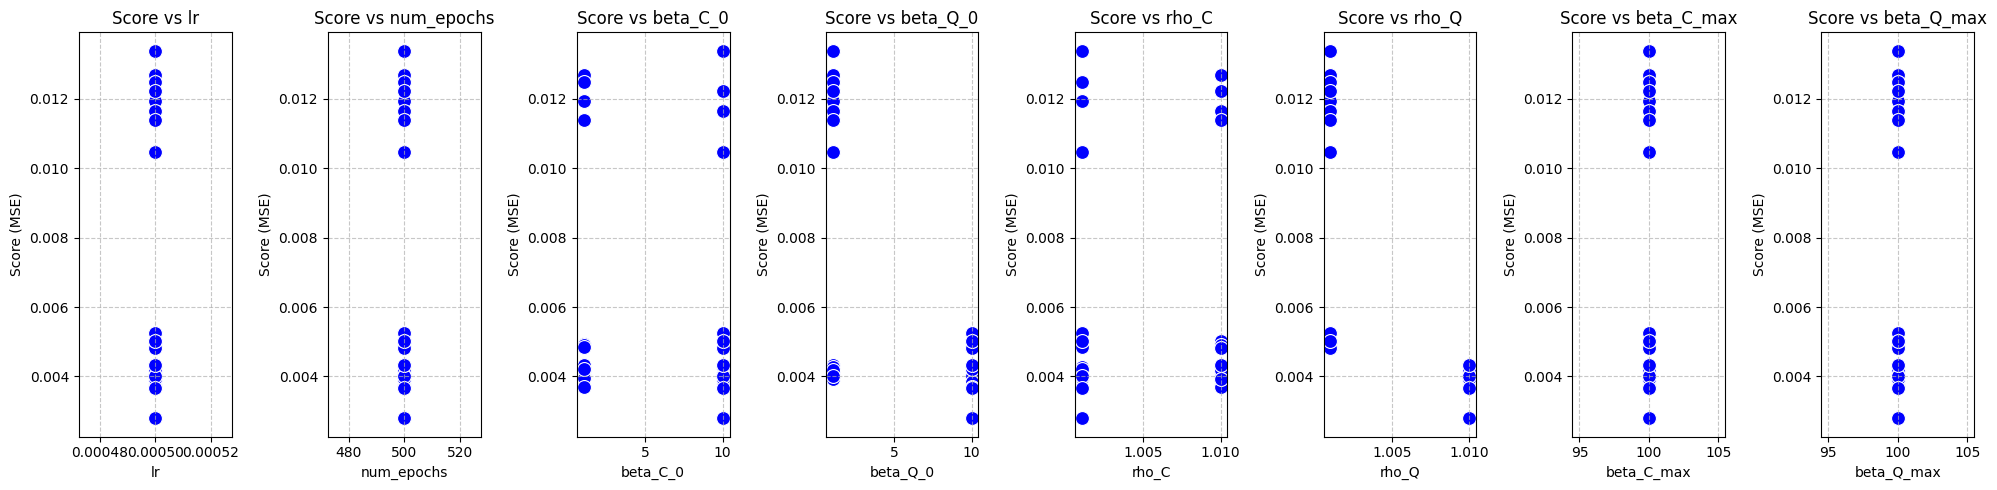

In [35]:
if isinstance(df_results['params'].iloc[0], str):
    df_results['params'] = df_results['params'].apply(ast.literal_eval)

# Tách cột params thành các cột riêng biệt (lr, num_epochs, ...)
params_df = pd.json_normalize(df_results['params'])

# Ghép lại với cột score để vẽ
df_plot = pd.concat([df_results[['score']], params_df], axis=1)

param_cols = params_df.columns

# Thiết lập kích thước khung hình
plt.figure(figsize=(20, 5))

# Vẽ vòng lặp
for i, col in enumerate(param_cols):
    plt.subplot(1, len(param_cols), i + 1)
    
    # Vẽ scatter plot (biểu đồ chấm)
    sns.scatterplot(data=df_plot, x=col, y='score', s=100, color='blue')
    
    # Vẽ đường xu hướng (tùy chọn, giúp dễ nhìn trend)
    # sns.regplot(data=df_plot, x=col, y='score', scatter=False, color='red')
    
    plt.title(f'Score vs {col}')
    plt.xlabel(col)
    plt.ylabel('Score (MSE)')
    plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()